# Checking model quality
## Import libraries

In [ ]:
import yaml
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, Literal, Any, List
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

sns.set_style("darkgrid")

## Load data

In [2]:
def _load_data(path: str | pathlib.Path) -> pd.DataFrame:
    """Loads CSV data in DataFrame format from specific path"""
    data = pd.read_csv(path, index_col="id")
    return data


def load_yaml_config(path: str | pathlib.Path):
    """Loads YAML config as Python dictionary"""
    with open(path, "r") as stream:
        config = yaml.safe_load(stream)
        return config


def get_train_data(
    client_type: str | Literal["new_client", "old_client"],
    ohe: bool = False
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Splits train data into features and targets
    
    Returns: 
    - features: features dataframe
    - targets: targets series
    """
    # Load data
    data = _load_data("../data/processed/train_dataset.csv")

    # Apply client config settings to data
    data_config = load_yaml_config("../configs/data.yaml")
    client_config = data_config.get(client_type, None)
    assert client_config, f"There is no '{client_type}' client type"

    # Pick consequent columns
    targets = data[client_config["target"]]
    features = data[client_config["features"]]

    # One-Hot-Encoding (if necessary)
    if ohe:
        features = pd.get_dummies(features, columns=client_config["cat"])

    return (features, targets)

In [3]:
def get_classifier(client_type: str | Literal["new_client", "old_client"]) -> Any:
    model_path = None
    match(client_type):
        case "new_client": 
            model_path = pathlib.Path("../artifacts/models/best_catboost_new_client_model_v1.cbm")
        case "old_client": 
            model_path = pathlib.Path("../artifacts/models/best_catboost_old_client_model_v1.cbm")
        case _: 
            raise Exception(f"There is no such a client type: {client_type}")

    model = CatBoostClassifier()
    model.load_model(model_path)
    return model


## 1. New client (PR AUC)

In [4]:
CLIENT_TYPE = "new_client"
features, targets = get_train_data(CLIENT_TYPE)
data_config = load_yaml_config("../configs/data.yaml")
pool = Pool(features, targets, cat_features=data_config[CLIENT_TYPE]["cat"])
model = get_classifier(CLIENT_TYPE)

In [5]:
def draw_confusion_matrix(
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int],
    classes: pd.Series | List
) -> None:
    cm = confusion_matrix(targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.grid(False)
    plt.show()

In [6]:
def expected_cost(
    y_true: pd.Series | List | pd.DataFrame, 
    y_proba: pd.Series | List | pd.DataFrame, 
    threshold: float,
    C_fp: float,
    C_fn: float,
) -> float:
    """Returns expected cost of money losts"""
    y_pred = (y_proba >= threshold).astype(int)
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    return C_fp * fp + C_fn * fn


def optimize_threshold(
    y_true: pd.Series | List | pd.DataFrame,
    y_proba: pd.Series | List | pd.DataFrame,
    C_fp: float,
    C_fn: float,
) -> float:
    """
    Finds best threshold according to input data by optimization precision-recall curve.
    """
    # Get PRC keypoints
    prec, rec, ths = precision_recall_curve(y_true, y_proba)

    # Adds 1.0 threshold
    ths = np.append(ths, 1.0)

    # Looking for best threshold
    best_threshold, best_cost = 0.5, expected_cost(y_true, y_proba, 0.5, C_fp, C_fn)
    for t in ths:
        cost = expected_cost(y_true, y_proba, t, C_fp, C_fn)
        if cost < best_cost:
            best_cost, best_threshold = cost, t
    return best_threshold

In [7]:
y_pred_proba = model.predict_proba(pool)[:, 1]

In [8]:
best_threshold = optimize_threshold(y_true=targets, y_proba=y_pred_proba, C_fp=1.0, C_fn=10.0)
y_pred = (y_pred_proba > best_threshold).astype(int)

In [9]:
best_threshold

np.float64(0.09650696275024365)

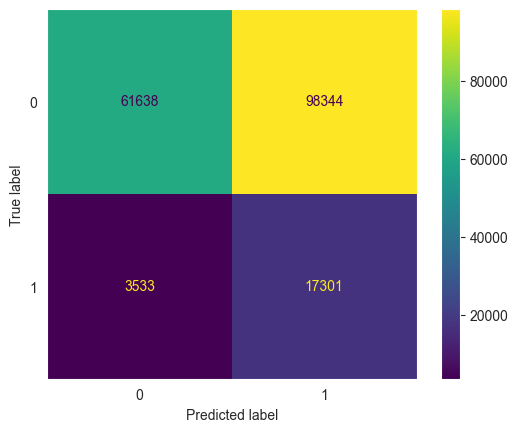

In [10]:
draw_confusion_matrix(targets, y_pred, classes=model.classes_)

In [11]:
def plot_roc( 
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int]
):
    roc_auc = roc_auc_score(targets, predictions)

    # Для построения кривой ROC
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def plot_pr( 
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int]
):
    pr_auc = average_precision_score(targets, predictions)

    # Для построения кривой ROC
    fpr, tpr, thresholds = precision_recall_curve(targets, predictions)
    plt.plot(fpr, tpr, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.plot([1, 0], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

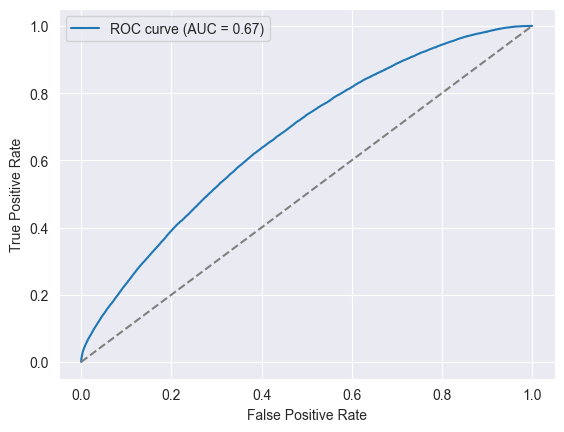

In [12]:
plot_roc(targets=targets, predictions=y_pred_proba)

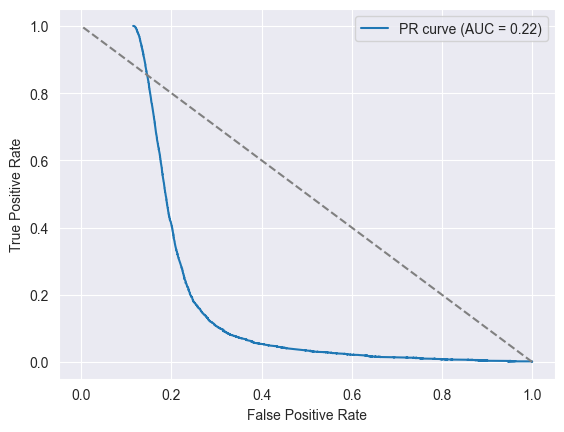

In [13]:
plot_pr(targets=targets, predictions=y_pred_proba)

## 2. Old clients

In [14]:
CLIENT_TYPE = "old_client"
features, targets = get_train_data(CLIENT_TYPE)
data_config = load_yaml_config("../configs/data.yaml")
pool = Pool(features, targets, cat_features=data_config[CLIENT_TYPE]["cat"])
model = get_classifier(CLIENT_TYPE)

In [15]:
y_pred_proba = model.predict_proba(pool)[:, 1]

In [16]:
best_threshold = optimize_threshold(y_true=targets, y_proba=y_pred_proba, C_fp=1.0, C_fn=10.0)
y_pred = (y_pred_proba > best_threshold).astype(int)

In [17]:
best_threshold

np.float64(0.45007191967085397)

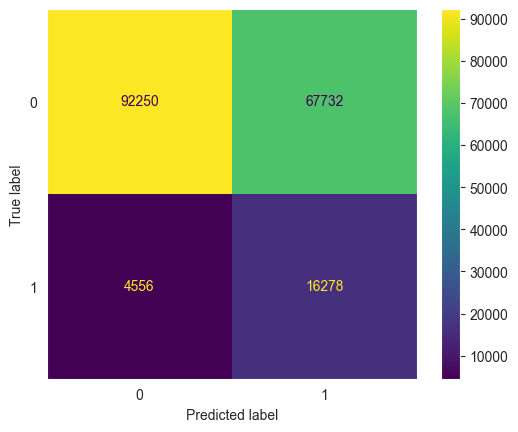

In [18]:
draw_confusion_matrix(targets, y_pred, classes=model.classes_)

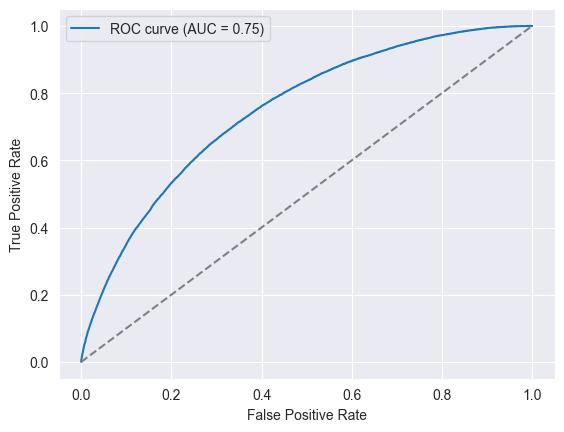

In [19]:
plot_roc(targets=targets, predictions=y_pred_proba)

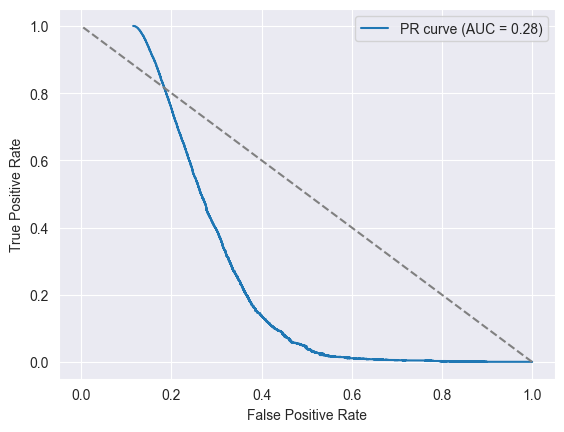

In [20]:
plot_pr(targets=targets, predictions=y_pred_proba)

In [21]:
ratio = targets.value_counts().iloc[1] / targets.value_counts().iloc[0]
ratio.item()*100

13.022715055443737

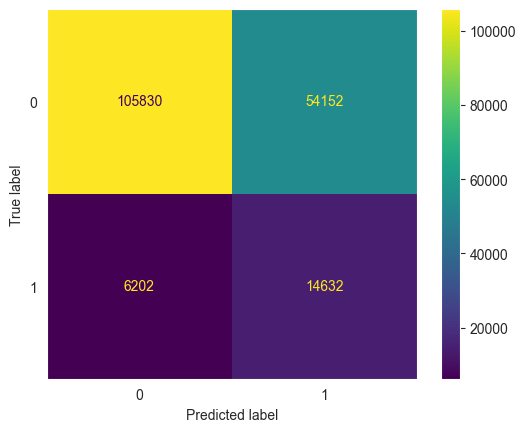

In [22]:
y_pred = model.predict(pool)
draw_confusion_matrix(targets, y_pred, classes=model.classes_)